# Gesture Recognition
By: Simranjeet Singh and Kartik Mehra


---



---


In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
# tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip "/content/gdrive/MyDrive/Data Science 2020-21/Project_data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [6]:
data_loc = "/content/Project_data"
train_doc = np.random.permutation(open(data_loc + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_loc+'/val.csv').readlines())


In [8]:
batch_size = 8

In [ ]:
# We have tried with batch size 16, 32,64.
# For 32 and 64 it was taking much RAM and colab stopped working.

#Thn out of 8 and 16. * is giving good results for Con3D models.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(100,100))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        remaining = len(t) % batch_size
        print(remaining)
        if remaining != 0:
            batch_data = np.zeros((remaining,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*remaining)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(100,100))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255                    
                batch_labels[folder, int(t[folder + (batch*remaining)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [11]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
testGen = generator(train_path,train_doc,batch_size)

In [14]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)

Source path =  /content/Project_data/train ; batch size = 8


In [15]:
batch_data.shape

(8, 15, 100, 100, 3)

In [16]:
inputShape = batch_data[0].shape
inputShape

(15, 100, 100, 3)

In [18]:
#Checking the input images

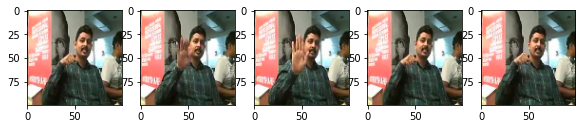

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range(1,6):
  ax = plt.subplot(2,10, i)
  plt.imshow(batch_data[2][i-1])

- testing the generator and displaying the few images from one video

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [50]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.applications import mobilenet #for transfer learning
#write your model here

In [22]:
from tensorflow.keras import backend as K
K.clear_session()

**Model 1 (Using Conv3D) Basic model**

In [23]:
Input_shape = inputShape
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))


model.add(Conv3D(32, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))



model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
optimiser =Adam(0.001) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 50, 50, 32)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 25, 25, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [26]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [27]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
steps_per_epoch

83

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
history_basic = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 8
Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 2.2868 - categorical_accuracy: 0.2099Source path =  /content/Project_data/val ; batch size = 8
4
83/83 [==============================] - 139s 1s/step - loss: 2.2848 - categorical_accuracy: 0.2102 - val_loss: 1.8837 - val_categorical_accuracy: 0.2400
Epoch 2/10
83/83 [==============================] - 104s 1s/step - loss: 1.7422 - categorical_accuracy: 0.2700 - val_loss: 1.6658 - val_categorical_accuracy: 0.3000
Epoch 3/10
83/83 [==============================] - 105s 1s/step - loss: 1.5354 - categorical_accuracy: 0.3415 - val_loss: 1.2778 - val_categorical_accuracy: 0.4300
Epoch 4/10
83/83 [==============================] - 105s 1s/step - loss: 1.2454 - categorical_accuracy: 0.4594 - val_loss: 1.2767 - val_categorical_accuracy: 0.4400
Epoch 5/10
83/83 [==============================] - 106s 1s/step - loss: 1.1765 - categorical_accuracy: 0.5130 - val_loss: 1.2

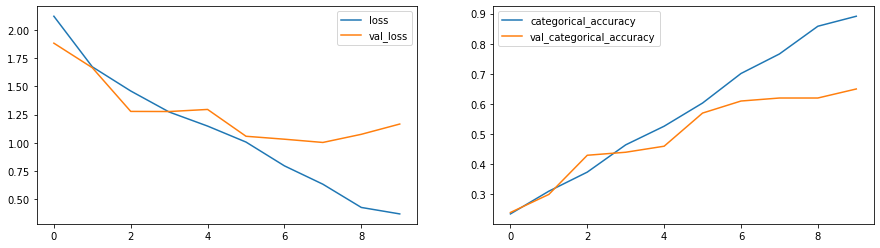

In [31]:
import matplotlib.pyplot as plt
% matplotlib inline
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
plot(history_basic)

__With 10 epoch our training accuracy and validation accuracy came out to be good.__

So now we will increase number of epochs and add some more dropout and regularization to overcome overfitting.

**Model 2 (Using Conv3D)**

In [32]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  /content/Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [33]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)



Input_shape = inputShape
model_2 = Sequential()
model_2.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))


model_2.add(Conv3D(32, (3, 3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv3D(64, (3, 3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))



model_2.add(Flatten())
model_2.add(Dense(64,kernel_regularizer=l2(0.01)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(128,kernel_regularizer=l2(0.01)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(5))
model_2.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())



# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 50, 50, 32)     0         
__________________________________________________

In [34]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

Source path =  /content/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 3.2555 - categorical_accuracy: 0.2120Source path =  /content/Project_data/val ; batch size = 8
4
83/83 [==============================] - 106s 1s/step - loss: 3.2504 - categorical_accuracy: 0.2122 - val_loss: 2.1861 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 2.18611, saving model to Model_2_2021-04-1910_55_50.646583/model-00001-2.82787-0.22926-2.18611-0.23000.h5
Epoch 2/20
83/83 [==============================] - 105s 1s/step - loss: 2.0802 - categorical_accuracy: 0.2493 - val_loss: 1.7001 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss improved from 2.18611 to 1.70007, saving model to Model_2_2021-04-1910_55_50.646583/model-00002-1.95524-0.28808-1.70007-0.43000.h5
Epoch 3/20
83/83 [==============================] - 104s 1s/step - loss: 1.6940 - categorical_accuracy: 0.3599 - val_loss: 1.5395 - val_categorical_accu

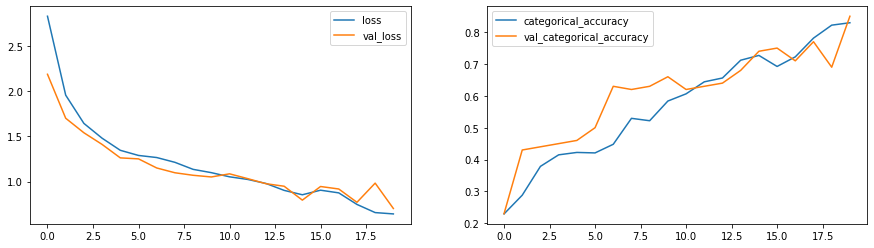

In [35]:
plot(history_2)

__We did see an improvement in accuracy for both training and validation.__

But still we will try to make it more steady.

**Model 3 (Using Conv3D)**

##### Model with more dropout percentage

In [36]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  /content/Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [37]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)


Input_shape = inputShape
model_3 = Sequential()
model_3.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model_3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.3))


model_3.add(Conv3D(32, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.3))

model_3.add(Conv3D(64, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.2))



model_3.add(Flatten())
model_3.add(Dense(64,kernel_regularizer=l2(0.01)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(128,kernel_regularizer=l2(0.01)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.4))

model_3.add(Dense(5))
model_3.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())



# training sequences = 663
# validation sequences = 100
# epochs = 25
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_13 (Activation)   (None, 7, 50, 50, 32)     0         
__________________________________________________

In [38]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

Source path =  /content/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 3.3260 - categorical_accuracy: 0.1829Source path =  /content/Project_data/val ; batch size = 8
4
83/83 [==============================] - 107s 1s/step - loss: 3.3208 - categorical_accuracy: 0.1832 - val_loss: 2.3154 - val_categorical_accuracy: 0.4300

Epoch 00001: val_loss improved from inf to 2.31541, saving model to Model_3_2021-04-1911_30_58.713977/model-00001-2.88975-0.21418-2.31541-0.43000.h5
Epoch 2/25
83/83 [==============================] - 105s 1s/step - loss: 2.1868 - categorical_accuracy: 0.2056 - val_loss: 1.9164 - val_categorical_accuracy: 0.2400

Epoch 00002: val_loss improved from 2.31541 to 1.91638, saving model to Model_3_2021-04-1911_30_58.713977/model-00002-2.08555-0.19306-1.91638-0.24000.h5
Epoch 3/25
83/83 [==============================] - 105s 1s/step - loss: 1.8721 - categorical_accuracy: 0.1659 - val_loss: 1.7672 - val_categorical_accu

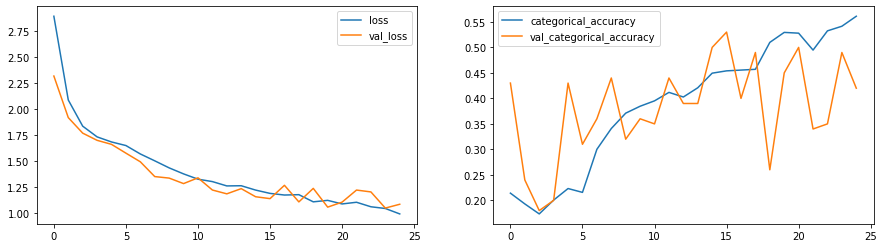

In [39]:
plot(history_3)

**Observation:**
- Loss and Val loss looks good.
- But there is alot of fluctuation on accuracy graph.
- So in the next model we will increase the number of epochs and give more time to model for learning.

**Model 4 (Using Conv3D)**

In [40]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  /content/Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [41]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)


Input_shape = inputShape
model_3_1 = Sequential()
model_3_1.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model_3_1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.3))


model_3_1.add(Conv3D(32, (3, 3,3), padding='same'))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.3))

model_3_1.add(Conv3D(64, (3, 3,3), padding='same'))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.2))



model_3_1.add(Flatten())
model_3_1.add(Dense(64,kernel_regularizer=l2(0.01)))
model_3_1.add(Activation('relu'))
model_3_1.add(Dropout(0.4))
model_3_1.add(Dense(128,kernel_regularizer=l2(0.01)))
model_3_1.add(Activation('relu'))
model_3_1.add(Dropout(0.4))

model_3_1.add(Dense(5))
model_3_1.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_3_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3_1.summary())



# training sequences = 663
# validation sequences = 100
# epochs = 40
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_18 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_19 (Activation)   (None, 7, 50, 50, 32)     0         
__________________________________________________

In [42]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_3_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_3_1 = model_3_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

Source path =  /content/Project_data/train ; batch size = 8
Epoch 1/40
83/83 [==============================] - ETA: 0s - loss: 3.2155 - categorical_accuracy: 0.2067Source path =  /content/Project_data/val ; batch size = 8
4
83/83 [==============================] - 107s 1s/step - loss: 3.2106 - categorical_accuracy: 0.2068 - val_loss: 2.1975 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 2.19746, saving model to Model_3_1_2021-04-1912_16_06.550357/model-00001-2.80697-0.21418-2.19746-0.30000.h5
Epoch 2/40
83/83 [==============================] - 105s 1s/step - loss: 2.0393 - categorical_accuracy: 0.2873 - val_loss: 1.7724 - val_categorical_accuracy: 0.4100

Epoch 00002: val_loss improved from 2.19746 to 1.77243, saving model to Model_3_1_2021-04-1912_16_06.550357/model-00002-1.95405-0.32127-1.77243-0.41000.h5
Epoch 3/40
83/83 [==============================] - 105s 1s/step - loss: 1.6945 - categorical_accuracy: 0.3434 - val_loss: 1.4286 - val_categorical_

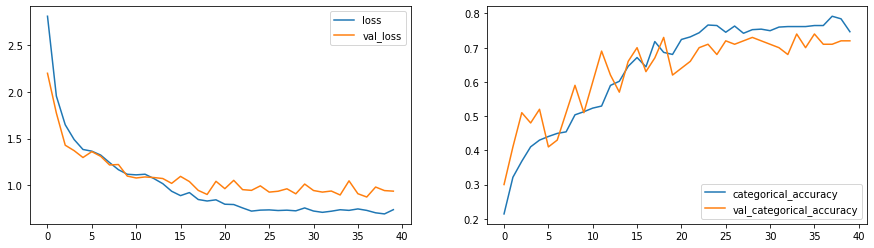

In [43]:
plot(history_3_1)

**Observation:**
- Model is looks good.
- We have least number of fluctuation in the end.
- So far this is the best model using Conv3D.

**Now Lets try with Conv2D + RNN models.**

Will use Tansfer Learnging + GRU for this Assignment.

**MODEL 5 (Tansfer Learning + GRU base model)**

Will use the batch size as 16.


---

Will use the same generator function.

In [53]:
batch_size = 16

In [54]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  /content/Project_data/train ; batch size = 16


(15, 100, 100, 3)

In [59]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

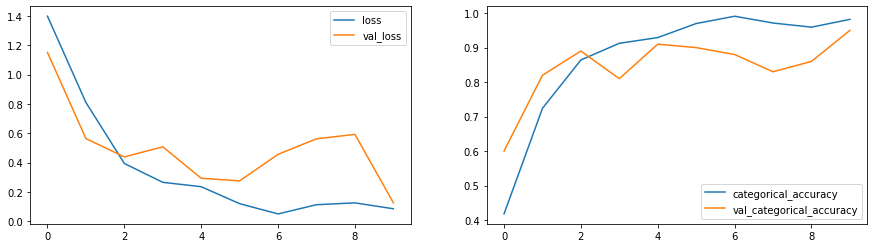

In [58]:
model_name = 'Model_3_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 1 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_1 = Sequential()
model_gru_1.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_1.add(TimeDistributed(BatchNormalization()))
model_gru_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_1.add(TimeDistributed(Flatten()))

model_gru_1.add(GRU(64))
model_gru_1.add(Dropout(0.3))

model_gru_1.add(Dense(64,activation='relu'))
model_gru_1.add(Dropout(0.3))

model_gru_1.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_1.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=10
model_gru_1=model_gru_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_1)

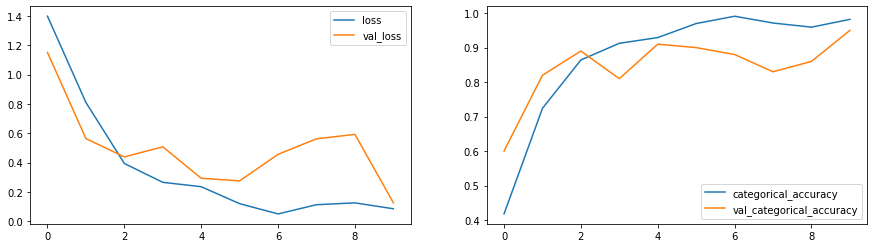

In [64]:
plot(model_gru_1)

**Observations:**
- Getting approx 95 training accuracy and 92 validation accuracy.
- Will experiment by removing the dropout in the next model.

**MODEL 6 (Tansfer Learning + GRU)**


---

Reduced dropout and checking again for 5 epoch

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)               

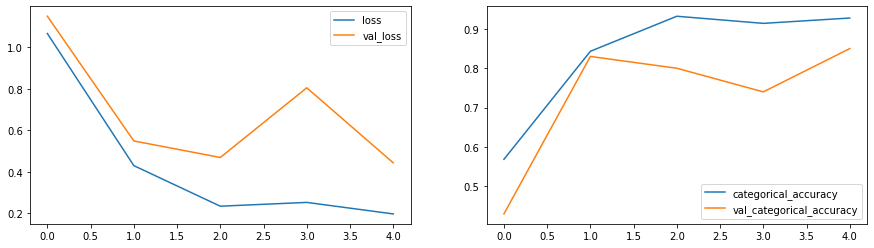

In [60]:
model_name = 'Model_TL_GRU_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 1 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_2 = Sequential()
model_gru_2.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_2.add(TimeDistributed(BatchNormalization()))
model_gru_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_2.add(TimeDistributed(Flatten()))

model_gru_2.add(GRU(64))
model_gru_2.add(Dropout(0.2))

model_gru_2.add(Dense(64,activation='relu'))

model_gru_2.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_2.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=5
model_gru_2=model_gru_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_2)


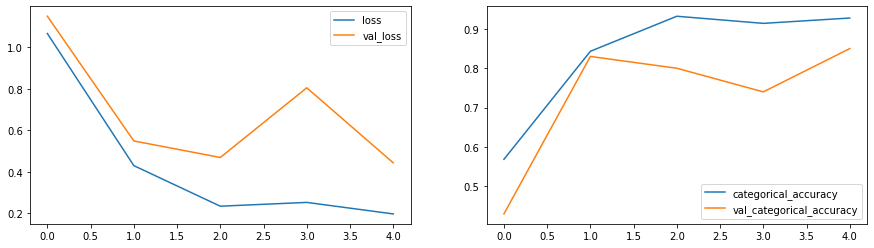

In [68]:
plot(model_gru_2)

**Observations:**
- Not getting the clear picture by using 5 epochs. 
- But model looks ok.

**MODEL 7 (Transfer Learning + GRU)**

---

In this model we are using model no 6 and increasing the number of epochs. Because we cann't predict using 5 epochs. So. lets re-observe after increasing the epochs from 5 to 20.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_23 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)              

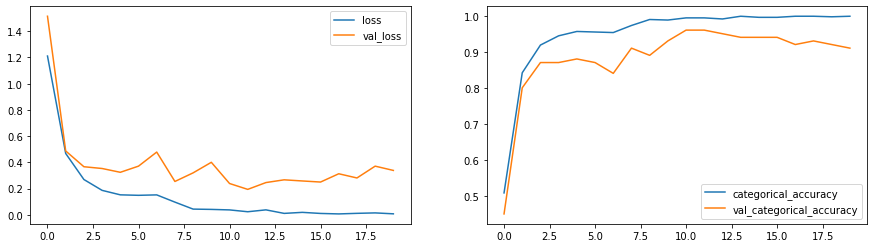

In [61]:
model_name = 'Model_TL_GRU_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 3 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_3 = Sequential()
model_gru_3.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_3.add(TimeDistributed(BatchNormalization()))
model_gru_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_3.add(TimeDistributed(Flatten()))

model_gru_3.add(GRU(64))
model_gru_3.add(Dropout(0.2))

model_gru_3.add(Dense(64,activation='relu'))

model_gru_3.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_3.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=20
model_gru_3=model_gru_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_3)


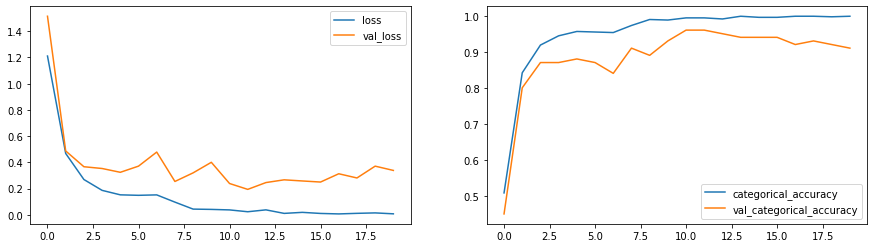

In [66]:
plot(model_gru_3)

**Observations:**
- This model looks good.
- Taining Accuracy lies between: 95-98
- Validation Accuracy lies between: 92-95

**MODEL 8 (Transfer Learning + GRU)**

---

Model 7 looks good but still we will try to reduce the training and validation gap a little more.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)              

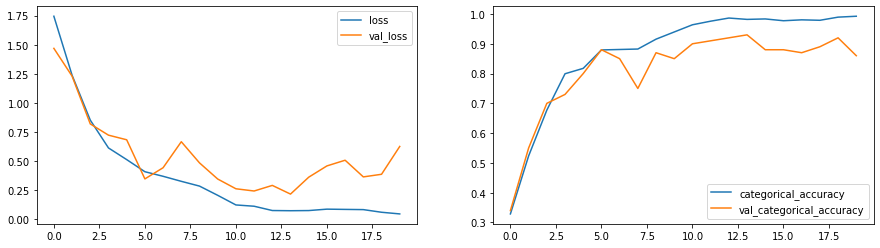

In [63]:
model_name = 'Model_TL_GRU_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 4 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_5 = Sequential()
model_gru_5.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_5.add(TimeDistributed(BatchNormalization()))
model_gru_5.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_5.add(TimeDistributed(Flatten()))

model_gru_5.add(GRU(64))
model_gru_5.add(Dropout(0.5))

model_gru_5.add(Dense(64,activation='relu'))
model_gru_5.add(Dropout(0.5))

model_gru_5.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_5.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=20
model_gru_5=model_gru_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_5)


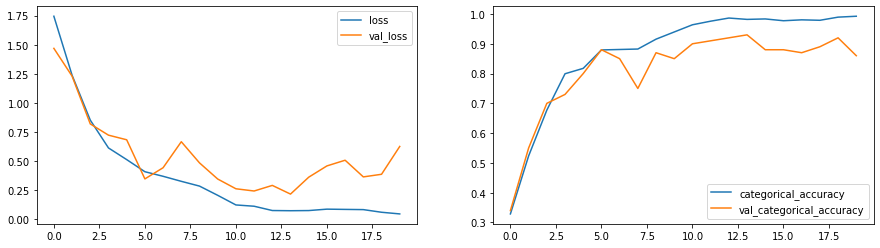

In [67]:
plot(model_gru_5)

**Observations:**
- This model also looks good but not better than model 7. 
- Taining Accuracy lies between: 94-97
- Validation Accuracy lies between: 88-92

# **CONCLUSION :**

So out of Conv3d and Conv2d+RNN we will go with the Conv2d+RNN which is **Model 7** because of its higher accuracy and stability.

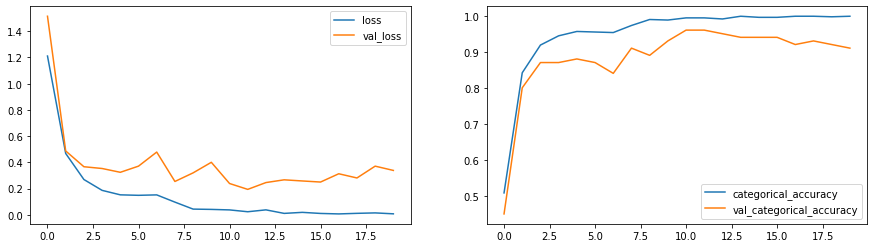

In [69]:
plot(model_gru_3)